In [ ]:
!pip install opencv-python numpy


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import zipfile


zip_path = r"D:\FracAtlas.zip" #r is for raw string to avoid escape sequences

# Step 2: Where to extract
extract_to = r"D:\FracAtlas_extracted"

# Step 3: Extract all files if not already extracted
if not os.path.exists(extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("✅ Files extracted to:", extract_to)
else:
    print("⚠️ Files already extracted at:", extract_to)


✅ Files extracted to: D:\FracAtlas_extracted


In [ ]:
# Step 4: Build path to the image you want
image_path = os.path.join(extract_to, "FracAtlas", "images", "Fractured", "IMG0000777.jpg")
print("Looking for:", image_path)

Looking for: D:\FracAtlas_extracted\FracAtlas\images\Fractured\IMG0000777.jpg


In [11]:
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# cv2.imread(path, cv2.imread_grayscale): loads the image in black and white (grayscale) mode.

✅ Image loaded. Shape: (454, 373)


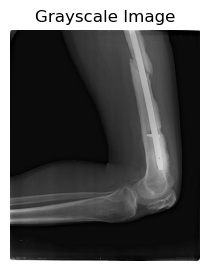

In [ ]:
if image is None:
    print("❌ Image not loaded. Check path again.")
else:
    print("✅ Image loaded. Shape:", image.shape) #gives dimensions of the image

    # Step 6: Show image
    plt.figure(figsize=(3,3))
    plt.imshow(image, cmap="gray") #show as grayscale, cmap: colormap
    plt.title("Grayscale Image")
    plt.axis("off")
    plt.show()

✅ Image loaded. Shape: (454, 373)
✅ Cropped image shape: (453, 372)
mask [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


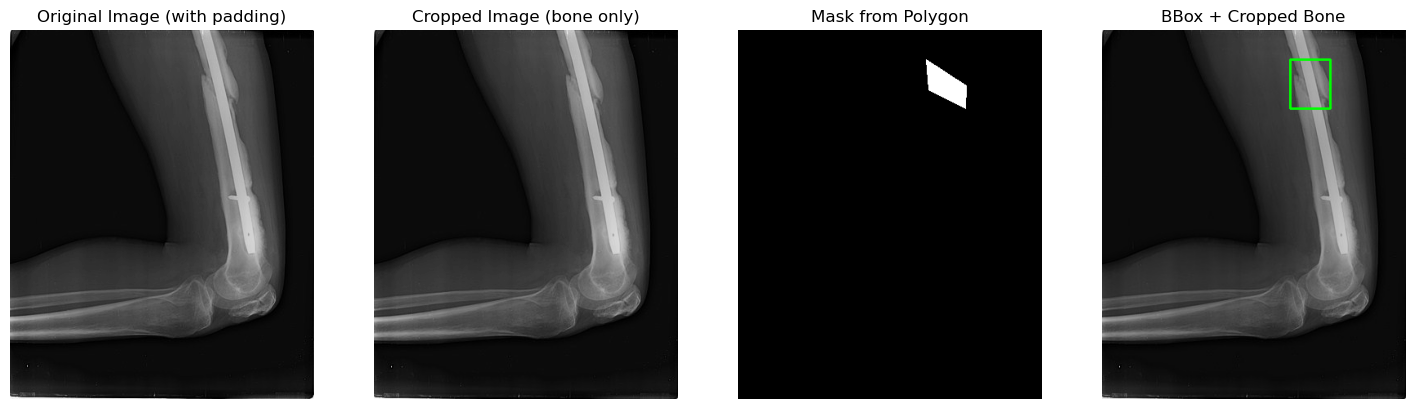

In [ ]:
# --- Import required libraries ---
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Load your grayscale image ---
image_path = r"D:\FracAtlas_extracted\FracAtlas\images\Fractured\IMG0000777.jpg"  
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    print("❌ Image not loaded. Please check the path again.")
    exit()

print("✅ Image loaded. Shape:", image.shape)

# --- Step 2: Example Annotation Dictionary (update with your JSON values) ---
annotation = {
    "id": 59,  #annotation ID
      "iscrowd": 0, #0: object is single, not in a group
      "image_id": 50, #which image this annotation belongs to
      "category_id": 0, #class label(0 is for fractured bone)
      "segmentation": [ #polygon points around the object
        [
          234.2502054231717, 74.60969597370584, 279.01602300739523,
          98.11175020542318, 280.1351684470008, 69.38701725554643,
          231.26581758422347, 37.67789646672145
        ]
      ],
      "bbox": [  #bounding box: [x, y, width, height]
        231.26581758422347, 37.67789646672145, 48.86935086277734,
        60.43385373870173
      ],
      "area": 1511.1945629195825 #area of annotated region
}

# Assume original dataset size (from JSON metadata, adjust if available)
# If your JSON has "height" and "width", replace here
orig_h, orig_w = image.shape[0], image.shape[1]  
#image.shape[0]: gives original height
#image.shape[1]: gives original width


# --- Step 3: Auto-crop black padding ---
coords = np.argwhere(image > 0)  # find non-black pixels
y_min, x_min = coords.min(axis=0)  #coords.min(axis =0): smallest(top-left corner)
y_max, x_max = coords.max(axis=0)  #coords.max(axis = 0): largest(bottom - right corner)


cropped = image[y_min:y_max, x_min:x_max] # crops out only the bone, removes black padding

print("✅ Cropped image shape:", cropped.shape)

# --- Step 4: Scale segmentation points ---
segmentation = np.array(annotation["segmentation"][0]).reshape(-1, 2)
# converts segmentation  list into array of (x,y) points


scale_x = cropped.shape[1] / orig_w # how much width changed
scale_y = cropped.shape[0] / orig_h # how much height changed

polygon_points = np.array([ [int(x * scale_x) - x_min, int(y * scale_y) - y_min] for x, y in segmentation
], dtype=np.int32)  #scales all polygon points 
# subtracts x_min and y_min because we cropped the image, so we need to adjust the coordinates
#converts to integers for OpenCV


# --- Step 5: Create mask ---
mask = np.zeros(cropped.shape, dtype=np.uint8)
print("mask" , mask)  
# creates a black mask of the same size as the cropped image

#cv2.fillPoly: fills polygon with white color(255): fracture region becomes white
cv2.fillPoly(mask, [polygon_points], color=255)

# --- Step 6: Extract bounding box & scale ---
x, y, w, h = annotation["bbox"]
x1 = int(x * scale_x) - x_min
y1 = int(y * scale_y) - y_min
x2 = int((x + w) * scale_x) - x_min
y2 = int((y + h) * scale_y) - y_min
#extracts bounding box from JSON
#scales it and shift according to cropping
#(x1, y1) = top-left corner
#(x2, y2) = bottom-right corner


# --- Step 7: Draw bounding box ---
image_with_bbox = cv2.cvtColor(cropped, cv2.COLOR_GRAY2BGR)
cv2.rectangle(image_with_bbox, (x1, y1), (x2, y2), (0,255,0), 2)
#converts grayscale to BGR color so we can draw in green
#draws rectangle in green(0,255,0), thickness = 2


# --- Step 8: Overlay mask on cropped image ---
#combines cropped image and mask with 70% opacity(image) and 30% mask
#makes the fracture highlighted
overlay = cv2.addWeighted(cropped, 0.7, mask, 0.3, 0)

# --- Step 9: Show results ---
plt.figure(figsize=(18,6))
# creates a figure with 4 subplots in a single row 


# Original ima
plt.subplot(1,4,1)
plt.imshow(image, cmap="gray")
plt.title("Original Image (with padding)")
plt.axis("off") 

# Cropped
plt.subplot(1,4,2)
plt.imshow(cropped, cmap="gray")
plt.title("Cropped Image (bone only)")
plt.axis("off")

# Mask
plt.subplot(1,4,3)
plt.imshow(mask, cmap="gray")
plt.title("Mask from Polygon")
plt.axis("off")

# Bounding Box + Mask
plt.subplot(1,4,4)
plt.imshow(image_with_bbox)
plt.title("BBox + Cropped Bone")
plt.axis("off")

plt.show()


In [39]:
# --- Ensure dtype is uint8 ---
if cropped.dtype != np.uint8:
    cropped_uint8 = cv2.normalize(cropped, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
else:
    cropped_uint8 = cropped

# --- Ensure mask size matches cropped image size ---
if mask.shape != cropped_uint8.shape:
    print("Mask and cropped image sizes differ! Fixing with resize...")
    mask_resized = cv2.resize(mask, (cropped_uint8.shape[1], cropped_uint8.shape[0]), interpolation=cv2.INTER_NEAREST)
else:
    mask_resized = mask

# --- 1. Intensity values of cropped image ---
min_val_image = np.min(cropped_uint8)
max_val_image = np.max(cropped_uint8)

print("Cropped Image Intensity:")
print("   ➝ Min:", min_val_image)
print("   ➝ Max:", max_val_image)

# --- 2. Intensity values inside fracture mask ---
masked_region = cv2.bitwise_and(cropped_uint8, cropped_uint8, mask=mask_resized)
non_zero_pixels = masked_region[mask_resized > 0]

if non_zero_pixels.size > 0:
    min_val_mask = np.min(non_zero_pixels)
    max_val_mask = np.max(non_zero_pixels)
    mean_val_mask = np.mean(non_zero_pixels)
else:
    min_val_mask, max_val_mask, mean_val_mask = None, None, None

print("\nMasked Region (Fracture) Intensity:")
print("   ➝ Min:", min_val_mask)
print("   ➝ Max:", max_val_mask)
print("   ➝ Mean:", mean_val_mask)


Mask and cropped image sizes differ! Fixing with resize...
Cropped Image Intensity:
   ➝ Min: 0
   ➝ Max: 235

Masked Region (Fracture) Intensity:
   ➝ Min: 56
   ➝ Max: 180
   ➝ Mean: 120.98838797814207


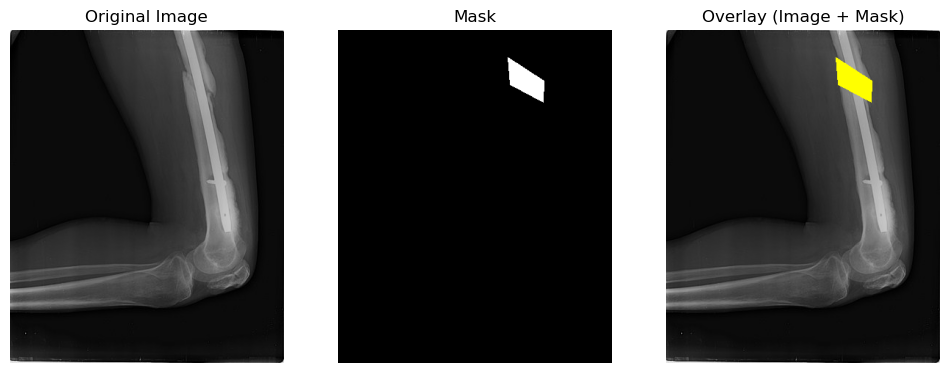

In [ ]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt

# # ---- Your annotation data ----
# annotation = {
#    "id": 59,
#       "iscrowd": 0,
#       "image_id": 50,
#       "category_id": 0,
#       "segmentation": [
#         [
#           234.2502054231717, 74.60969597370584, 279.01602300739523,
#           98.11175020542318, 280.1351684470008, 69.38701725554643,
#           231.26581758422347, 37.67789646672145
#         ]
#       ],
#       "bbox": [
#         231.26581758422347, 37.67789646672145, 48.86935086277734,
#         60.43385373870173
#       ],
#       "area": 1511.1945629195825
# }

# # ---- Load the actual image ----
# image_path = r"D:\FracAtlas_extracted\FracAtlas\images\Fractured\IMG0000777.jpg"
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert BGR→RGB for matplotlib
# height, width = image.shape[:2]

# # ---- Create empty mask ----
# mask = np.zeros((height, width), dtype=np.uint8)

# # ---- Draw polygon from segmentation ----
# for seg in annotation["segmentation"]:
#     points = np.array(seg).reshape((-1, 2)).astype(np.int32)
#     cv2.fillPoly(mask, [points], 1)

# # ---- Show outputs (inline only) ----
# plt.figure(figsize=(12,6))

# # Original image
# plt.subplot(1, 3, 1)
# plt.imshow(image)
# plt.title("Original Image")
# plt.axis("off")

# # Mask only
# plt.subplot(1, 3, 2)
# plt.imshow(mask, cmap="gray")
# plt.title("Mask")
# plt.axis("off")

# # Overlay (image + mask in red)
# overlay = image.copy()
# overlay[mask == 1] = [255, 255, 0]  
# plt.subplot(1, 3, 3)
# plt.imshow(overlay)
# plt.title("Overlay (Image + Mask)")
# plt.axis("off")

# plt.show()
